In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 

file_path = '/kaggle/input/natural-questions/Natural-Questions-Base.csv' 
df = pd.read_csv(file_path)

In [3]:
df = df.drop(columns=['short_answers'])
df = df.rename(columns={'long_answers': 'answer'})

In [4]:
df

,question,answer
0,which is the most common use of opt-in e-mail ...,<P> A common example of permission marketing i...
1,how i.met your mother who is the mother,"<P> Tracy McConnell , better known as `` The M..."
2,what type of fertilisation takes place in humans,<P> The process of fertilization involves a sp...
3,who had the most wins in the nfl,<P> Active quarterback Tom Brady holds the rec...
4,what happened to the lost settlement of roanoke,NaN
...,...,...
307368,who have been the hosts of the price is right,<P> The Price Is Right is a television game sh...
307369,who sang the song mama told me not to come,NaN
307370,who plays grey worm on game of thrones,<P> Jacob Basil Anderson ( born 18 June 1990 )...
307371,working principle of high pressure sodium vapo...,NaN


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


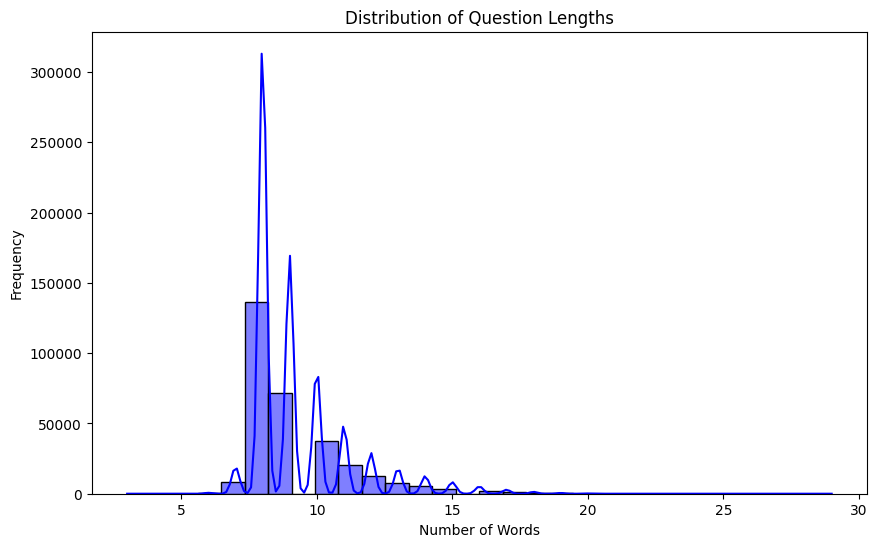

In [5]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['question'].apply(lambda x: len(str(x).split())), bins=30, kde=True, color='blue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Summary
df_info = df.info()


print(df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307373 entries, 0 to 307372
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   question  307373 non-null  object
 1   answer    152148 non-null  object
dtypes: object(2)
memory usage: 4.7+ MB
None


# Data cleaning

### Remove NaN values

In [7]:
nan_percentage = df.isna().mean() * 100


print("\nPercentage of NaN values for each column:")
print(nan_percentage)


Percentage of NaN values for each column:
question     0.000000
answer      50.500532
dtype: float64


In [8]:
#check the rows with missing values

missing_answers = df[df['answer'].isna()]
print(missing_answers)


                                                 question answer
4         what happened to the lost settlement of roanoke    NaN
5       what are the different regions of africa and h...    NaN
7       who did the voice of the magician in frosty th...    NaN
9       what is considered the outer banks in north ca...    NaN
11      bangko sentral ng pilipinas (central bank of t...    NaN
...                                                   ...    ...
307365     who is the killer in and then there were fewer    NaN
307366     btm 1st stage comes under which police station    NaN
307367           who is the chairman of google at present    NaN
307369         who sang the song mama told me not to come    NaN
307371  working principle of high pressure sodium vapo...    NaN

[155225 rows x 2 columns]


In [9]:
df = df.dropna(subset=['answer'])


In [10]:
df

,question,answer
0,which is the most common use of opt-in e-mail ...,<P> A common example of permission marketing i...
1,how i.met your mother who is the mother,"<P> Tracy McConnell , better known as `` The M..."
2,what type of fertilisation takes place in humans,<P> The process of fertilization involves a sp...
3,who had the most wins in the nfl,<P> Active quarterback Tom Brady holds the rec...
6,who played mantis guardians of the galaxy 2,<P> Pom Klementieff ( born 3 May 1986 ) is a F...
...,...,...
307362,who said no to this is your life,<P> Footballer Danny Blanchflower turned down ...
307364,what was the rationale behind the american inv...,<P> American expansion into the Northwest Terr...
307368,who have been the hosts of the price is right,<P> The Price Is Right is a television game sh...
307370,who plays grey worm on game of thrones,<P> Jacob Basil Anderson ( born 18 June 1990 )...


### Remove duplicates

In [10]:
df = df.drop_duplicates()


### Trim Whitespace

In [11]:
df['question'] = df['question'].str.strip()
df['answer'] = df['answer'].str.strip()


### Convert to Lowercase

In [12]:
df['question'] = df['question'].str.lower()
df['answer'] = df['answer'].str.lower()


### Remove html tags

In [13]:
import re

def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)


df['answer'] = df['answer'].apply(remove_html_tags)



In [14]:
df

,question,answer
0,which is the most common use of opt-in e-mail ...,a common example of permission marketing is a...
1,how i.met your mother who is the mother,"tracy mcconnell , better known as `` the moth..."
2,what type of fertilisation takes place in humans,the process of fertilization involves a sperm...
3,who had the most wins in the nfl,active quarterback tom brady holds the record...
6,who played mantis guardians of the galaxy 2,pom klementieff ( born 3 may 1986 ) is a fren...
...,...,...
307362,who said no to this is your life,footballer danny blanchflower turned down the...
307364,what was the rationale behind the american inv...,american expansion into the northwest territo...
307368,who have been the hosts of the price is right,the price is right is a television game show ...
307370,who plays grey worm on game of thrones,jacob basil anderson ( born 18 june 1990 ) is...


In [15]:
# Check for missing answers
missing_answers = df['answer'].isnull().sum()

if missing_answers > 0:
    print(f"There are {missing_answers} questions without corresponding answers.")
else:
    print("All questions have corresponding answers.")


All questions have corresponding answers.


### **Data Preparation for Model Training**

In [61]:
# Define maximum vocabulary size and sequence length
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 500  
EMBEDDING_DIM = 300  

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['question'].values + df['answer'].values)

# Convert questions and answers to sequences
X = tokenizer.texts_to_sequences(df['question'].values)
y = tokenizer.texts_to_sequences(df['answer'].values)

# Pad the sequences to have the same length
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH)



X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# **Embeddings**

In [62]:
# Load GloVe embeddings
def load_glove_embeddings(file_path, word_index, embedding_dim, max_vocab_size):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((max_vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < max_vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

glove_file_path = '/kaggle/input/glove6b/glove.6B.300d.txt'
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer.word_index, EMBEDDING_DIM, MAX_VOCAB_SIZE)


KeyboardInterrupt



#  **Build BiLSTM Model**

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense


# Define the model
model = Sequential()
model.add(Embedding(input_dim=MAX_VOCAB_SIZE, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    weights=[embedding_matrix], 
                    trainable=False))  
model.add(Bidirectional(LSTM(64, return_sequences=True)))  
model.add(Dropout(0.5)) 
model.add(Dense(MAX_VOCAB_SIZE, activation='softmax'))  

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# # **Train Bi-Lstm Model**

In [83]:
# Train the model
history_bilstm = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)


Epoch 1/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 637s 334ms/step - accuracy: 0.7369 - loss: 2.5875 - val_accuracy: 0.7460 - val_loss: 2.0999
Epoch 2/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 634s 333ms/step - accuracy: 0.7447 - loss: 2.1358 - val_accuracy: 0.7460 - val_loss: 2.0655
Epoch 3/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 634s 333ms/step - accuracy: 0.7436 - loss: 2.1219 - val_accuracy: 0.7461 - val_loss: 2.0548
Epoch 4/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 634s 333ms/step - accuracy: 0.7443 - loss: 2.1002 - val_accuracy: 0.7462 - val_loss: 2.0467
Epoch 5/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 634s 333ms/step - accuracy: 0.7452 - loss: 2.0822 - val_accuracy: 0.7462 - val_loss: 2.0393
Epoch 6/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 634s 334ms/step - accuracy: 0.7443 - loss: 2.0816 - val_accuracy: 0.7462 - val_loss: 2.0274
Epoch 7/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 635s 334ms/step - accuracy: 0.7436 - loss: 2.0728 - val_accuracy: 0.7462 - val_loss: 2.0181
Epoch 8/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 635s 334ms/step - ac

**Model Loss vs accuracy**

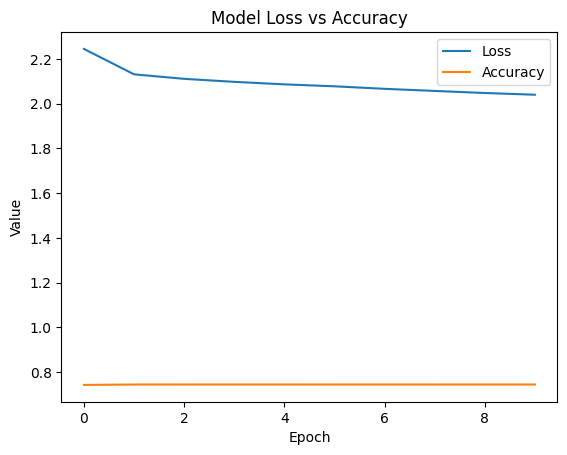

In [84]:
from matplotlib import pyplot as plt


plt.plot(history_bilstm.history['loss'], label='Loss')
plt.plot(history_bilstm.history['accuracy'], label='Accuracy')


plt.title('Model Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')


plt.legend(['Loss', 'Accuracy'], loc='upper right')


plt.show()


**Example question**

In [ ]:

question = "who is the mother in how i met your mother?"

# Tokenize and pad the input question
question_seq = tokenizer.texts_to_sequences([question])
question_pad = pad_sequences(question_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


predicted_answer_seq = model.predict(question_pad)


predicted_answer = tokenizer.sequences_to_texts(predicted_answer_seq.argmax(axis=-1))


print("Model's answer:", predicted_answer)


# # **Bi-RNN model**

# **Build Model**

In [69]:
# Define the model
modelRnn = Sequential()
modelRnn.add(Embedding(input_dim=MAX_VOCAB_SIZE, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    weights=[embedding_matrix], 
                    trainable=False))  
modelRnn.add(Bidirectional(SimpleRNN(64, return_sequences=True)))  
modelRnn.add(Dropout(0.5)) 
modelRnn.add(Dense(MAX_VOCAB_SIZE, activation='softmax')) 

# Compile model
modelRnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# **Train Bi-RNN Model**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with both early stopping and learning rate reduction
history = modelRnn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=10,  
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr])  


In [70]:
# Train the model
history = modelRnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

Epoch 1/10


I0000 00:00:1729550064.065776      78 service.cc:145] XLA service 0x7e210c2faa20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729550064.065871      78 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729550064.065881      78 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1729550064.356403      78 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


   1/1902 ━━━━━━━━━━━━━━━━━━━━ 4:34:33 9s/step - accuracy: 3.1250e-05 - loss: 9.1877

I0000 00:00:1729550070.150533      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1901/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7309 - loss: 2.7252

W0000 00:00:1729550434.545471      81 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1902/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7309 - loss: 2.7251

W0000 00:00:1729550440.294546      81 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1729550474.431812      81 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1902/1902 ━━━━━━━━━━━━━━━━━━━━ 414s 213ms/step - accuracy: 0.7309 - loss: 2.7249 - val_accuracy: 0.7403 - val_loss: 2.3000
Epoch 2/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 398s 209ms/step - accuracy: 0.7392 - loss: 2.3734 - val_accuracy: 0.7403 - val_loss: 2.2989
Epoch 3/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 398s 209ms/step - accuracy: 0.7388 - loss: 2.3685 - val_accuracy: 0.7425 - val_loss: 2.3045
Epoch 4/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 398s 209ms/step - accuracy: 0.7406 - loss: 2.3482 - val_accuracy: 0.7403 - val_loss: 2.3017
Epoch 5/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 398s 209ms/step - accuracy: 0.7410 - loss: 2.3419 - val_accuracy: 0.7403 - val_loss: 2.3042
Epoch 6/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 398s 209ms/step - accuracy: 0.7400 - loss: 2.3444 - val_accuracy: 0.7424 - val_loss: 2.3009
Epoch 7/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 398s 209ms/step - accuracy: 0.7400 - loss: 2.3428 - val_accuracy: 0.7403 - val_loss: 2.3000
Epoch 8/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 398s 209ms/step - accuracy: 0.7

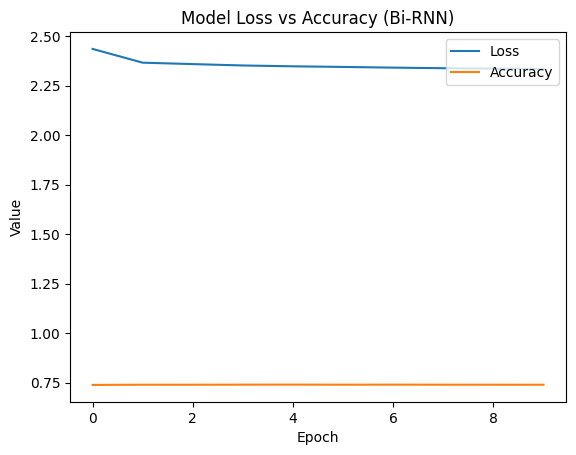

In [71]:
# Plot Loss vs Accuracy for Bi-RNN model
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')

plt.title('Model Loss vs Accuracy (Bi-RNN)')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.legend(['Loss', 'Accuracy'], loc='upper right')
plt.show()

# **Transformers**

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"  
tokenizer = BertTokenizer.from_pretrained(model_name)

# Ensure X_train and X_val are lists of strings
# Convert to strings if necessary
X_train = [str(x) for x in X_train]
X_val = [str(x) for x in X_val]



# Tokenize input data
X_train_encoded = tokenizer(
    X_train,
    padding=True,
    truncation=True,
    max_length=MAX_SEQUENCE_LENGTH,
    return_tensors='tf'
)

X_val_encoded = tokenizer(
    X_val,
    padding=True,
    truncation=True,
    max_length=MAX_SEQUENCE_LENGTH,
    return_tensors='tf'
)

# Check the shape of the tokenized inputs
print("X_train_encoded input_ids shape:", X_train_encoded['input_ids'].shape)
print("X_val_encoded input_ids shape:", X_val_encoded['input_ids'].shape)

# Load BERT model for sequence classification
modelBERT = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=MAX_VOCAB_SIZE)

# Compile the model
modelBERT.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model without callbacks for testing
history = modelBERT.fit(
    X_train_encoded['input_ids'], y_train,
    validation_data=(X_val_encoded['input_ids'], y_val),
    epochs=10,
    batch_size=64
)



X_train_encoded input_ids shape: (121718, 500)
X_val_encoded input_ids shape: (30430, 500)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ResourceExhaustedError: Graph execution error:

Detected at node tf_bert_for_sequence_classification_1/bert/encoder/layer_._2/intermediate/Gelu/truediv defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_30/144750892.py", line 50, in <module>

  File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1229, in fit

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1669, in train_step

  File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1672, in train_step

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_filedktkbbac.py", line 34, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs

  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1746, in call

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_filedktkbbac.py", line 34, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs

  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 969, in call

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_filedktkbbac.py", line 34, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 603, in call

  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 609, in call

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_filedktkbbac.py", line 34, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 548, in call

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_filedktkbbac.py", line 34, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 432, in call

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/activations.py", line 453, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/activations.py", line 465, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/tf_keras/src/activations.py", line 348, in gelu

failed to allocate memory
	 [[{{node tf_bert_for_sequence_classification_1/bert/encoder/layer_._2/intermediate/Gelu/truediv}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1145127]

In [ ]:
# Plot Loss vs Accuracy for BERT model
plt.plot(history.history['loss'], label='Loss')
plt.plot(hitory.history['accuracy'], label='Accuracy')

plt.title('Model Loss vs Accuracy (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.legend(['Loss', 'Accuracy'], loc='upper right')
plt.show()